Phase 1: SOC → Categories → Jobs
This cell contains the code to load and merge your raw Excel data, then calculate the median score for each of your six categories (Communication, Responsibility, Physical, Criticality, Routine, and Skills) for every SOC code. It now includes a step to normalize these scores to a 0-100 scale.

In [32]:
# Phase 1: SOC -> Categories -> Jobs (Final Corrected Version)
import os
import pandas as pd
import numpy as np
import logging

logging.basicConfig(level=logging.INFO, format="%(levelname)s - %(message)s")

DATA_DIR = r"C:\Users\acer\OneDrive\Labor Market Project\Data"
PHASE1_OUTPUT_FILE = os.path.join(DATA_DIR, "SOC_Categories_Phase1.xlsx")

CATEGORY_MAP = {
    "Face-to-Face_Discussions_with_Individuals_and_Within_Teams.xlsx": "Communication",
    "Public_Speaking.xlsx": "Communication",
    "Work_Outcomes_and_Results_of_Other_Workers.xlsx": "Responsibility",
    "Health_and_Safety_of_Other_Workers.xlsx": "Responsibility",
    "Determine_Tasks_Priorities_and_Goals.xlsx": "Routine",
    "Outdoors_Exposed_to_All_Weather_Conditions.xlsx": "Physical",
    "Physical_Proximity.xlsx": "Physical",
    "Consequence_of_Error.xlsx": "Criticality",
    "Frequency_of_Decision_Making.xlsx": "Criticality",
    "Degree_of_Automation.xlsx": "Routine",
    "Freedom_to_Make_Decisions.xlsx": "Criticality",
    "AIOE_DataAppendix.xlsx": "AIOE"
}

JOB_ZONE_FILES = {
    "Job_Zone_One_Little_or_No_Preparation_Needed.xlsx": 1,
    "Job_Zone_Two_Some_Preparation_Needed.xlsx": 2,
    "Job_Zone_Three_Medium_Preparation_Needed.xlsx": 3,
    "Job_Zone_Four_Considerable_Preparation_Needed.xlsx": 4,
    "Job_Zone_Five_Extensive_Preparation_Needed.xlsx": 5
}

def load_data_from_files(data_dir):
    all_dfs = []
    
    # Handle Job Zone files and create 'Skills' column
    for file_name, job_zone_value in JOB_ZONE_FILES.items():
        file_path = os.path.join(data_dir, file_name)
        if os.path.exists(file_path):
            try:
                df = pd.read_excel(file_path, header=None, skiprows=4)
                df.columns = ["SOC_Code", "Occupation"]
                df["Skills"] = job_zone_value
                df = df.dropna(subset=["SOC_Code", "Occupation"])
                all_dfs.append(df[["SOC_Code", "Occupation", "Skills"]])
                logging.info(f"Loaded {file_name} successfully.")
            except Exception as e:
                logging.warning(f"Could not load {file_name}: {e}")

    # Handle all other files
    for file_name, category_name in CATEGORY_MAP.items():
        file_path = os.path.join(data_dir, file_name)
        if os.path.exists(file_path):
            try:
                if file_name == "AIOE_DataAppendix.xlsx":
                    df = pd.read_excel(file_path, sheet_name="Appendix A")
                    df.columns = [col.strip() for col in df.columns]
                    df = df.rename(columns={"SOC Code": "SOC_Code", "Occupation Title": "Occupation"})
                    df = df[["SOC_Code", "Occupation", "AIOE"]]
                elif file_name in ["Consequence_of_Error.xlsx", "Frequency_of_Decision_Making.xlsx", "Freedom_to_Make_Decisions.xlsx", "Determine_Tasks_Priorities_and_Goals.xlsx", "Degree_of_Automation.xlsx"]:
                    df = pd.read_excel(file_path, header=None, skiprows=3)
                    df.columns = [category_name, "Job Zone", "SOC_Code", "Occupation"]
                    df = df.dropna(subset=["SOC_Code", "Occupation"])
                    df[category_name] = pd.to_numeric(df[category_name], errors='coerce')
                    df = df[["SOC_Code", "Occupation", category_name]]
                else:
                    df = pd.read_excel(file_path, header=None, skiprows=2)
                    df.columns = [category_name, "Context", "SOC_Code", "Occupation"]
                    df = df.dropna(subset=["SOC_Code", "Occupation"])
                    df[category_name] = pd.to_numeric(df[category_name], errors='coerce')
                    df = df[["SOC_Code", "Occupation", category_name]]
                all_dfs.append(df)
                logging.info(f"Loaded {file_name} successfully.")
            except Exception as e:
                logging.warning(f"Could not load {file_name}: {e}")

    if not all_dfs:
        logging.error("No relevant data files found to merge.")
        return pd.DataFrame()

    merged_df = pd.concat(all_dfs, ignore_index=True)
    
    return merged_df

# Main execution
raw_df = load_data_from_files(DATA_DIR)

if not raw_df.empty:
    # Standardize SOC codes to 6-digit format to combine duplicates
    raw_df['SOC_Code'] = raw_df['SOC_Code'].astype(str).str.replace(r'\.\d+$', '', regex=True)

    # Group by SOC_Code and Occupation, taking median values
    soc_df = raw_df.groupby(["SOC_Code", "Occupation"]).median().reset_index()
    
    # Normalize scores to 0-100 scale
    for col in ['Communication', 'Responsibility', 'Physical', 'Criticality', 'Routine', 'Skills']:
        if col in soc_df.columns:
            col_min = soc_df[col].min()
            col_max = soc_df[col].max()
            if col_max != col_min:
                soc_df[col] = 100 * (soc_df[col] - col_min) / (col_max - col_min)
            else:
                soc_df[col] = 0
                
    soc_df.to_excel(PHASE1_OUTPUT_FILE, index=False)
    print("Phase 1 complete. Category scores saved.")
    print(f"Final dataset shape: {soc_df.shape}")
    print(f"Columns: {list(soc_df.columns)}")
    print("\nFirst few rows:")
    print(soc_df.head())
else:
    print("No data was successfully loaded and merged.")

INFO - Loaded Job_Zone_One_Little_or_No_Preparation_Needed.xlsx successfully.


INFO - Loaded Job_Zone_Two_Some_Preparation_Needed.xlsx successfully.
INFO - Loaded Job_Zone_Three_Medium_Preparation_Needed.xlsx successfully.
INFO - Loaded Job_Zone_Four_Considerable_Preparation_Needed.xlsx successfully.
INFO - Loaded Job_Zone_Five_Extensive_Preparation_Needed.xlsx successfully.
INFO - Loaded Face-to-Face_Discussions_with_Individuals_and_Within_Teams.xlsx successfully.
INFO - Loaded Public_Speaking.xlsx successfully.
INFO - Loaded Work_Outcomes_and_Results_of_Other_Workers.xlsx successfully.
INFO - Loaded Health_and_Safety_of_Other_Workers.xlsx successfully.
INFO - Loaded Determine_Tasks_Priorities_and_Goals.xlsx successfully.
INFO - Loaded Outdoors_Exposed_to_All_Weather_Conditions.xlsx successfully.
INFO - Loaded Physical_Proximity.xlsx successfully.
INFO - Loaded Consequence_of_Error.xlsx successfully.
INFO - Loaded Frequency_of_Decision_Making.xlsx successfully.
INFO - Loaded Degree_of_Automation.xlsx successfully.
INFO - Loaded Freedom_to_Make_Decisions.xlsx suc

Phase 1 complete. Category scores saved.
Final dataset shape: (1123, 9)
Columns: ['SOC_Code', 'Occupation', 'Skills', 'Communication', 'Responsibility', 'Routine', 'Physical', 'Criticality', 'AIOE']

First few rows:
  SOC_Code                           Occupation  Skills  Communication  \
0  11-1011                     Chief Executives   100.0          73.75   
1  11-1011        Chief Sustainability Officers   100.0          67.50   
2  11-1021      General and Operations Managers    75.0          63.75   
3  11-1031                          Legislators    75.0            NaN   
4  11-2011  Advertising and Promotions Managers    75.0          65.00   

   Responsibility    Routine   Physical  Criticality      AIOE  
0       86.904762  77.118644  30.000000    87.179487  1.334246  
1       51.190476  55.084746  33.333333    57.692308       NaN  
2       86.904762  77.118644  48.333333    93.589744  0.574877  
3             NaN        NaN        NaN          NaN       NaN  
4       48.809

Phase 2: SOC → Complementarity (θ)
This cell uses the normalized scores from Phase 1 to calculate the complementarity score θ.

In [33]:
# Phase 2: The Theta Calculation
import os
import pandas as pd
import numpy as np

DATA_DIR = r"C:\Users\acer\OneDrive\Labor Market Project\Data"
PHASE1_OUTPUT_FILE = os.path.join(DATA_DIR, "SOC_Categories_Phase1.xlsx")
PHASE2_OUTPUT_FILE = os.path.join(DATA_DIR, "SOC_Complementarity_Phase2.xlsx")

try:
    soc_df = pd.read_excel(PHASE1_OUTPUT_FILE)
except FileNotFoundError:
    print("Error: Phase 1 output file not found. Please run Phase 1 first.")

# The formula is: θi = +Communication + Responsibility + Physical + Criticality + Skills - Routine
soc_df["Theta"] = (
    soc_df["Communication"]
    + soc_df["Responsibility"]
    + soc_df["Physical"]
    + soc_df["Criticality"]
    + soc_df["Skills"]
    - soc_df["Routine"]
)

# Normalize Theta to a 0-100 scale
theta_min = soc_df["Theta"].min()
theta_max = soc_df["Theta"].max()
if theta_max != theta_min:
    soc_df["Theta_Normalized"] = 100 * (soc_df["Theta"] - theta_min) / (theta_max - theta_min)
else:
    soc_df["Theta_Normalized"] = 0

soc_df.to_excel(PHASE2_OUTPUT_FILE, index=False)
print("Phase 2 complete. Theta scores saved.")
print(soc_df.head())

Phase 2 complete. Theta scores saved.
  SOC_Code                           Occupation  Skills  Communication  \
0  11-1011                     Chief Executives   100.0          73.75   
1  11-1011        Chief Sustainability Officers   100.0          67.50   
2  11-1021      General and Operations Managers    75.0          63.75   
3  11-1031                          Legislators    75.0            NaN   
4  11-2011  Advertising and Promotions Managers    75.0          65.00   

   Responsibility    Routine   Physical  Criticality      AIOE       Theta  \
0       86.904762  77.118644  30.000000    87.179487  1.334246  300.715605   
1       51.190476  55.084746  33.333333    57.692308       NaN  254.631371   
2       86.904762  77.118644  48.333333    93.589744  0.574877  290.459195   
3             NaN        NaN        NaN          NaN       NaN         NaN   
4       48.809524  60.169492  37.222222    69.230769  1.294387  235.093024   

   Theta_Normalized  
0         84.299605  
1   

Phase 3: Classification Framework
This final cell uses the AIOE exposure data and the Theta score to classify each job.

In [37]:
# Phase 3: The Final Classification
import os
import pandas as pd
import numpy as np
import logging

logging.basicConfig(level=logging.INFO, format="%(levelname)s - %(message)s")

DATA_DIR = r"C:\Users\acer\OneDrive\Labor Market Project\Data"
OUTPUTS_DIR = os.path.join(os.path.dirname(DATA_DIR), "Outputs")

PHASE2_OUTPUT_FILE = os.path.join(DATA_DIR, "SOC_Complementarity_Phase2.xlsx")
FINAL_OUTPUT_FILE = os.path.join(OUTPUTS_DIR, "Final_Job_Classification.xlsx")

# Create the Outputs directory if it doesn't exist
if not os.path.exists(OUTPUTS_DIR):
    os.makedirs(OUTPUTS_DIR)

try:
    soc_with_theta_df = pd.read_excel(PHASE2_OUTPUT_FILE)
except FileNotFoundError:
    print("Error: Phase 2 output file not found. Please run Phase 2 first.")
    
# Fill NaN values with the median of their respective columns
soc_with_theta_df['AIOE'] = soc_with_theta_df['AIOE'].fillna(soc_with_theta_df['AIOE'].median())
soc_with_theta_df['Theta_Normalized'] = soc_with_theta_df['Theta_Normalized'].fillna(soc_with_theta_df['Theta_Normalized'].median())

if not soc_with_theta_df.empty:
    median_aioe = soc_with_theta_df["AIOE"].median()
    median_theta = soc_with_theta_df["Theta_Normalized"].median()

    soc_with_theta_df["Exposure"] = np.where(soc_with_theta_df["AIOE"] > median_aioe, "High", "Low")
    soc_with_theta_df["Complementarity"] = np.where(soc_with_theta_df["Theta_Normalized"] > median_theta, "High", "Low")
    
    def get_classification(row):
        if row["Exposure"] == "Low":
            return "Low Exposure (Minimal Impact)"
        elif row["Exposure"] == "High" and row["Complementarity"] == "High":
            return "High Exposure, High Complementarity (Augmentation)"
        elif row["Exposure"] == "High" and row["Complementarity"] == "Low":
            return "High Exposure, Low Complementarity (Displacement Risk)"
        return "Unknown"
    
    soc_with_theta_df["Classification"] = soc_with_theta_df.apply(get_classification, axis=1)
    
    output_cols = ["SOC_Code", "Occupation", "AIOE", "Exposure", "Theta_Normalized", "Complementarity", "Classification"]
    final_df = soc_with_theta_df[output_cols]
    final_df.to_excel(FINAL_OUTPUT_FILE, index=False)
    print("Phase 3 complete. Final job classification saved to the Outputs folder.")
    print(final_df.head())

Phase 3 complete. Final job classification saved to the Outputs folder.
  SOC_Code                           Occupation      AIOE Exposure  \
0  11-1011                     Chief Executives  1.334246     High   
1  11-1011        Chief Sustainability Officers -0.051193      Low   
2  11-1021      General and Operations Managers  0.574877     High   
3  11-1031                          Legislators -0.051193      Low   
4  11-2011  Advertising and Promotions Managers  1.294387     High   

   Theta_Normalized Complementarity  \
0         84.299605            High   
1         70.460280            High   
2         81.219554            High   
3         57.352630             Low   
4         64.592816            High   

                                      Classification  
0  High Exposure, High Complementarity (Augmentat...  
1                      Low Exposure (Minimal Impact)  
2  High Exposure, High Complementarity (Augmentat...  
3                      Low Exposure (Minimal Impact)

Added Standard Scaling

In [39]:
# Phase 3: The Final Classification
import os
import pandas as pd
import numpy as np
import logging
from sklearn.preprocessing import StandardScaler

logging.basicConfig(level=logging.INFO, format="%(levelname)s - %(message)s")

DATA_DIR = r"C:\Users\acer\OneDrive\Labor Market Project\Data"
OUTPUTS_DIR = os.path.join(os.path.dirname(DATA_DIR), "Outputs")

PHASE2_OUTPUT_FILE = os.path.join(DATA_DIR, "SOC_Complementarity_Phase2.xlsx")
FINAL_OUTPUT_FILE = os.path.join(OUTPUTS_DIR, "Final_Job_Classification.xlsx")

# Create the Outputs directory if it doesn't exist
if not os.path.exists(OUTPUTS_DIR):
    os.makedirs(OUTPUTS_DIR)

try:
    soc_with_theta_df = pd.read_excel(PHASE2_OUTPUT_FILE)
except FileNotFoundError:
    print("Error: Phase 2 output file not found. Please run Phase 2 first.")
    
# Fill NaN values with the median of their respective columns
soc_with_theta_df['AIOE'] = soc_with_theta_df['AIOE'].fillna(soc_with_theta_df['AIOE'].median())
soc_with_theta_df['Theta_Normalized'] = soc_with_theta_df['Theta_Normalized'].fillna(soc_with_theta_df['Theta_Normalized'].median())

# Perform Standard Scaling
scaler = StandardScaler()
soc_with_theta_df['AIOE_Scaled'] = scaler.fit_transform(soc_with_theta_df[['AIOE']])
soc_with_theta_df['Theta_Normalized_Scaled'] = scaler.fit_transform(soc_with_theta_df[['Theta_Normalized']])

if not soc_with_theta_df.empty:
    median_aioe = soc_with_theta_df["AIOE"].median()
    median_theta = soc_with_theta_df["Theta_Normalized"].median()

    soc_with_theta_df["Exposure"] = np.where(soc_with_theta_df["AIOE"] > median_aioe, "High", "Low")
    soc_with_theta_df["Complementarity"] = np.where(soc_with_theta_df["Theta_Normalized"] > median_theta, "High", "Low")
    
    def get_classification(row):
        if row["Exposure"] == "Low":
            return "Low Exposure (Minimal Impact)"
        elif row["Exposure"] == "High" and row["Complementarity"] == "High":
            return "High Exposure, High Complementarity (Augmentation)"
        elif row["Exposure"] == "High" and row["Complementarity"] == "Low":
            return "High Exposure, Low Complementarity (Displacement Risk)"
        return "Unknown"
    
    soc_with_theta_df["Classification"] = soc_with_theta_df.apply(get_classification, axis=1)
    
    output_cols = ["SOC_Code", "Occupation", "AIOE", "AIOE_Scaled", "Exposure", "Theta_Normalized", "Theta_Normalized_Scaled", "Complementarity", "Classification"]
    final_df = soc_with_theta_df[output_cols]
    final_df.to_excel(FINAL_OUTPUT_FILE, index=False)
    print("Phase 3 complete. Final job classification saved to the Outputs folder.")
    print(final_df.head())

Phase 3 complete. Final job classification saved to the Outputs folder.
  SOC_Code                           Occupation      AIOE  AIOE_Scaled  \
0  11-1011                     Chief Executives  1.334246     1.626698   
1  11-1011        Chief Sustainability Officers -0.051193    -0.042510   
2  11-1021      General and Operations Managers  0.574877     0.711793   
3  11-1031                          Legislators -0.051193    -0.042510   
4  11-2011  Advertising and Promotions Managers  1.294387     1.578675   

  Exposure  Theta_Normalized  Theta_Normalized_Scaled Complementarity  \
0     High         84.299605                 1.893580            High   
1      Low         70.460280                 0.941971            High   
2     High         81.219554                 1.681792            High   
3      Low         57.352630                 0.040673             Low   
4     High         64.592816                 0.538517            High   

                                      Classi

Histogram of Complementarity Scores

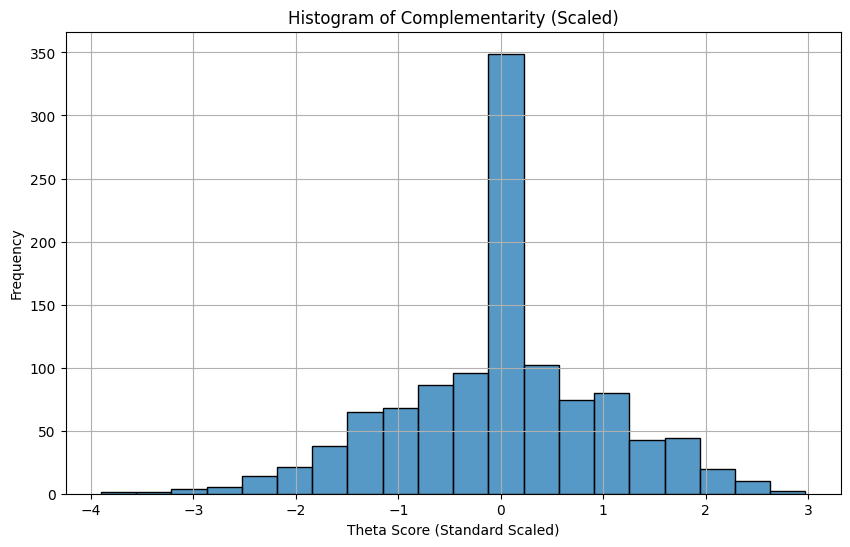

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the final dataset
final_df = pd.read_excel(r"C:\Users\acer\OneDrive\Labor Market Project\Outputs\Final_Job_Classification.xlsx")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=final_df, x="Theta_Normalized_Scaled", bins=20, kde=False)
plt.title("Histogram of Complementarity (Scaled)")
plt.xlabel("Theta Score (Standard Scaled)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Scatterplot of each Category 

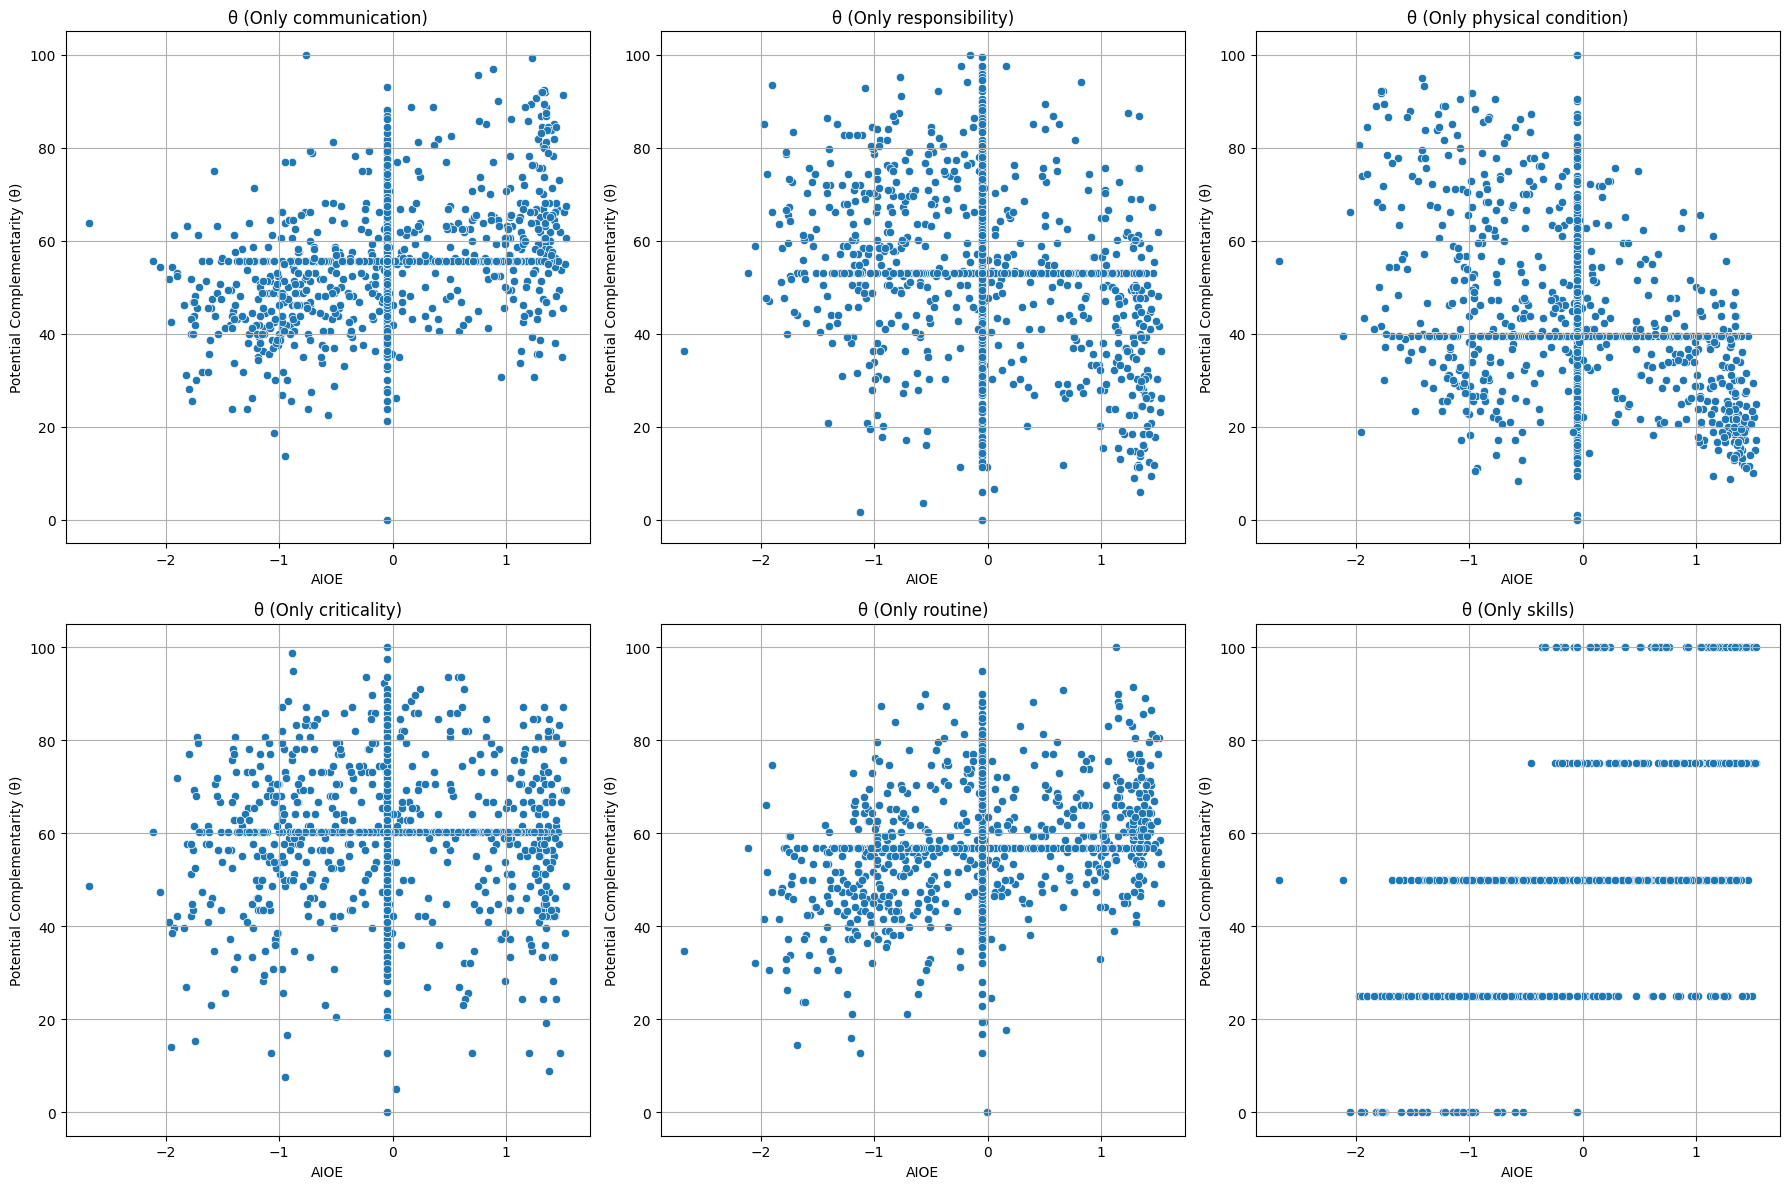

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Phase 1 data and standardize SOC codes
phase1_df = pd.read_excel(r"C:\Users\acer\OneDrive\Labor Market Project\Data\SOC_Categories_Phase1.xlsx")
phase1_df['SOC_Code'] = phase1_df['SOC_Code'].astype(str).str.replace(r'\.\d+$', '', regex=True)

# Since all the data is already in phase1_df, we don't need a separate merge
# Just use phase1_df directly as scatter_df
scatter_df = phase1_df.copy()

# Fill NaN values in the numeric columns
numeric_cols = ["Communication", "Responsibility", "Physical", "Criticality", "Routine", "Skills"]
for col in numeric_cols:
    scatter_df[col] = scatter_df[col].fillna(scatter_df[col].median())

# Fill NaN values in the AIOE column
scatter_df['AIOE'] = scatter_df['AIOE'].fillna(scatter_df['AIOE'].median())

# Create the scatter plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
components = ["Communication", "Responsibility", "Physical", "Criticality", "Routine", "Skills"]
titles = [
    "θ (Only communication)", "θ (Only responsibility)", "θ (Only physical condition)",
    "θ (Only criticality)", "θ (Only routine)", "θ (Only skills)"
]

axes = axes.flatten()

for i, (component, title) in enumerate(zip(components, titles)):
    sns.scatterplot(ax=axes[i], data=scatter_df, x="AIOE", y=component)
    axes[i].set_title(title)
    axes[i].set_xlabel("AIOE")
    axes[i].set_ylabel("Potential Complementarity (θ)")
    axes[i].grid(True)

plt.tight_layout()
plt.show()